In [2]:
import numpy as np
import pandas as pd
import torch

# config
INPUT = "/home/tidal/ML_Data/BMS_MolTrans/bms-molecular-translation"
OUTPUT = "/home/tidal/ML_Data/BMS_MolTrans/output"

train = pd.read_pickle('train2.pkl')

def get_train_file_path(image_id):
    return INPUT + "/train/{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )

train['file_path'] = train['image_id'].apply(get_train_file_path)

print(f'train.shape: {train.shape}')
display(train.head())

train.shape: (2424186, 6)


,image_id,InChI,InChI_1,InChI_text,InChI_length,file_path
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,C13H20OS,C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...,59,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,C21H30O4,C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8...,108,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,C24H23N5O4,C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 ...,112,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,C17H24N2O4S,C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 (...,108,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,C10H19N3O2S,C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 -...,72,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...


In [3]:
class Tokenizer(object):
    
    def __init__(self):
        self.stoi = {}
        self.itos = {}

    def __len__(self):
        return len(self.stoi)
    
    def fit_on_texts(self, texts):
        vocab = set()
        for text in texts:
            vocab.update(text.split(' '))
        vocab = sorted(vocab)
        vocab.append('<sos>')
        vocab.append('<eos>')
        vocab.append('<pad>')
        for i, s in enumerate(vocab):
            self.stoi[s] = i
        self.itos = {item[1]: item[0] for item in self.stoi.items()}
        
    def text_to_sequence(self, text):
        sequence = []
        sequence.append(self.stoi['<sos>'])
        for s in text.split(' '):
            sequence.append(self.stoi[s])
        sequence.append(self.stoi['<eos>'])
        return sequence
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = self.text_to_sequence(text)
            sequences.append(sequence)
        return sequences

    def sequence_to_text(self, sequence):
        return ''.join(list(map(lambda i: self.itos[i], sequence)))
    
    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = self.sequence_to_text(sequence)
            texts.append(text)
        return texts
    
    def predict_caption(self, sequence):
        caption = ''
        for i in sequence:
            if i == self.stoi['<eos>'] or i == self.stoi['<pad>']:
                break
            caption += self.itos[i]
        return caption
    
    def predict_captions(self, sequences):
        captions = []
        for sequence in sequences:
            caption = self.predict_caption(sequence)
            captions.append(caption)
        return captions

tokenizer = torch.load('tokenizer2.pth')
print(f"tokenizer.stoi: {tokenizer.stoi}")

tokenizer.stoi: {'(': 0, ')': 1, '+': 2, ',': 3, '-': 4, '/b': 5, '/c': 6, '/h': 7, '/i': 8, '/m': 9, '/s': 10, '/t': 11, '0': 12, '1': 13, '10': 14, '100': 15, '101': 16, '102': 17, '103': 18, '104': 19, '105': 20, '106': 21, '107': 22, '108': 23, '109': 24, '11': 25, '110': 26, '111': 27, '112': 28, '113': 29, '114': 30, '115': 31, '116': 32, '117': 33, '118': 34, '119': 35, '12': 36, '120': 37, '121': 38, '122': 39, '123': 40, '124': 41, '125': 42, '126': 43, '127': 44, '128': 45, '129': 46, '13': 47, '130': 48, '131': 49, '132': 50, '133': 51, '134': 52, '135': 53, '136': 54, '137': 55, '138': 56, '139': 57, '14': 58, '140': 59, '141': 60, '142': 61, '143': 62, '144': 63, '145': 64, '146': 65, '147': 66, '148': 67, '149': 68, '15': 69, '150': 70, '151': 71, '152': 72, '153': 73, '154': 74, '155': 75, '156': 76, '157': 77, '158': 78, '159': 79, '16': 80, '161': 81, '163': 82, '165': 83, '167': 84, '17': 85, '18': 86, '19': 87, '2': 88, '20': 89, '21': 90, '22': 91, '23': 92, '24': 9

In [4]:
train['InChI_length'].max()

275

In [5]:
train

,image_id,InChI,InChI_1,InChI_text,InChI_length,file_path
0,000011a64c74,InChI=1S/C13H20OS/c1-9(2)8-15-13-6-5-10(3)7-12...,C13H20OS,C 13 H 20 O S /c 1 - 9 ( 2 ) 8 - 15 - 13 - 6 -...,59,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...
1,000019cc0cd2,InChI=1S/C21H30O4/c1-12(22)25-14-6-8-20(2)13(1...,C21H30O4,C 21 H 30 O 4 /c 1 - 12 ( 22 ) 25 - 14 - 6 - 8...,108,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...
2,0000252b6d2b,InChI=1S/C24H23N5O4/c1-14-13-15(7-8-17(14)28-1...,C24H23N5O4,C 24 H 23 N 5 O 4 /c 1 - 14 - 13 - 15 ( 7 - 8 ...,112,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...
3,000026b49b7e,InChI=1S/C17H24N2O4S/c1-12(20)18-13(14-7-6-10-...,C17H24N2O4S,C 17 H 24 N 2 O 4 S /c 1 - 12 ( 20 ) 18 - 13 (...,108,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...
4,000026fc6c36,InChI=1S/C10H19N3O2S/c1-15-10(14)12-8-4-6-13(7...,C10H19N3O2S,C 10 H 19 N 3 O 2 S /c 1 - 15 - 10 ( 14 ) 12 -...,72,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...
...,...,...,...,...,...,...
2424181,ffffe824f539,InChI=1S/C10H12F2N2O3/c1-17-7-2-5(3-8(15)16)9(...,C10H12F2N2O3,C 10 H 12 F 2 N 2 O 3 /c 1 - 17 - 7 - 2 - 5 ( ...,71,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...
2424182,ffffea1ebdfa,InChI=1S/C19H20F2N4O3S/c1-10(8-20)28-14-7-12(2...,C19H20F2N4O3S,C 19 H 20 F 2 N 4 O 3 S /c 1 - 10 ( 8 - 20 ) 2...,119,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...
2424183,ffffee2b4534,InChI=1S/C22H26Cl2N2O4S/c1-16-6-2-3-10-21(16)3...,C22H26Cl2N2O4S,C 22 H 26 Cl 2 N 2 O 4 S /c 1 - 16 - 6 - 2 - 3...,114,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...
2424184,fffff0b6eea6,InChI=1S/C17H26N2O6S/c1-23-16-12-14(4-5-15(16)...,C17H26N2O6S,C 17 H 26 N 2 O 6 S /c 1 - 23 - 16 - 12 - 14 (...,90,/home/tidal/ML_Data/BMS_MolTrans/bms-molecular...


# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    max_len=275
    print_freq=1000
    num_workers=4
    model_name='resnet34'
    size=224
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=1 # not to exceed 9h
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=4 # CosineAnnealingLR
    #T_0=4 # CosineAnnealingWarmRestarts
    encoder_lr=1e-4
    decoder_lr=4e-4
    min_lr=1e-6
    batch_size=64
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=5
    attention_dim=256
    embed_dim=256
    decoder_dim=512
    dropout=0.5
    seed=42
    n_fold=5
    trn_fold=[0] # [0, 1, 2, 3, 4]
    train=True

In [7]:
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [12]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import gc
import re
import math
import time
import random
import shutil
import pickle
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import Levenshtein
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, Blur
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [15]:
# ====================================================
# Utils
# ====================================================
#レーベンシュタイン距離（今回のmetric）
def get_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        score = Levenshtein.distance(true, pred)
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score


def init_logger(log_file=OUTPUT+'/Log/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV split

In [16]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds['InChI_length'])): #どんな比で分けられている？
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold']).size())

fold
0    484838
1    484837
2    484837
3    484837
4    484837
dtype: int64


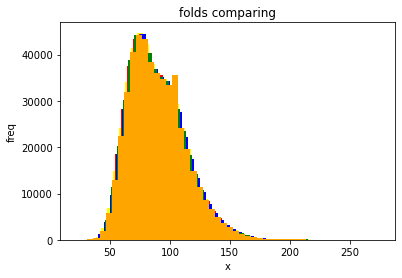

In [36]:
#分散比確かめ
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(folds[folds.fold == 0]["InChI_length"], bins=50, color='yellow')
ax.hist(folds[folds.fold == 1]["InChI_length"], bins=50, color='red')
ax.hist(folds[folds.fold == 2]["InChI_length"], bins=50, color='blue')
ax.hist(folds[folds.fold == 3]["InChI_length"], bins=50, color='green')
ax.hist(folds[folds.fold == 4]["InChI_length"], bins=50, color='orange')
ax.set_title('folds comparing')
ax.set_xlabel('x')
ax.set_ylabel('freq')
fig.show()

##